# Modeling-to-Generate-Alternatives (MGA) Tutorial

MGA is commonly used in energy modelling to address what is known as "structural uncertainty."
That is, the uncertainty stemming from unknown, unmodeled, or unmodel-able objectives. For instance,
political feasibility or some other qualitative variable.

## The MGA Idea

To get around this challenge, MGA searches the "sub-optimal" or "near-optimal" region for alternative
solutions by relaxing the objective function. The goal for a single-objective problem is to find 
"maximally different solutions in the design space." In multi-objective problems, specifically ones solved
with genetic algorithms, users can identify alternatives by random selection or farthest first traversal.

This tutorial will illustrate both methods.

## MGA Example \#1

In [1]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# pymoo imports
from pymoo.problems import get_problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from osier import n_mga

In [2]:
problem = get_problem("bnh")

pop_size = 100
n_gen = 200
algorithm = NSGA2(pop_size=pop_size)

res = minimize(problem,
               algorithm,
               ('n_gen', n_gen),
               seed=1,
               verbose=False,
               save_history=True
               )


In [5]:
F = problem.pareto_front()
a = min(F[:,0])
b = max(F[:,0])
f1 = F[:,0]
f2 = F[:,1]
shift = 0.75
slack = 0.2
alpha = 0.5
F1 = f1 * (1+slack)
F2 = f2 * (1+slack)

In [6]:
X_hist = np.array([history.pop.get("X") for history in res.history]).reshape(n_gen*pop_size,2)
F_hist = np.array([history.pop.get("F") for history in res.history]).reshape(n_gen*pop_size,2)

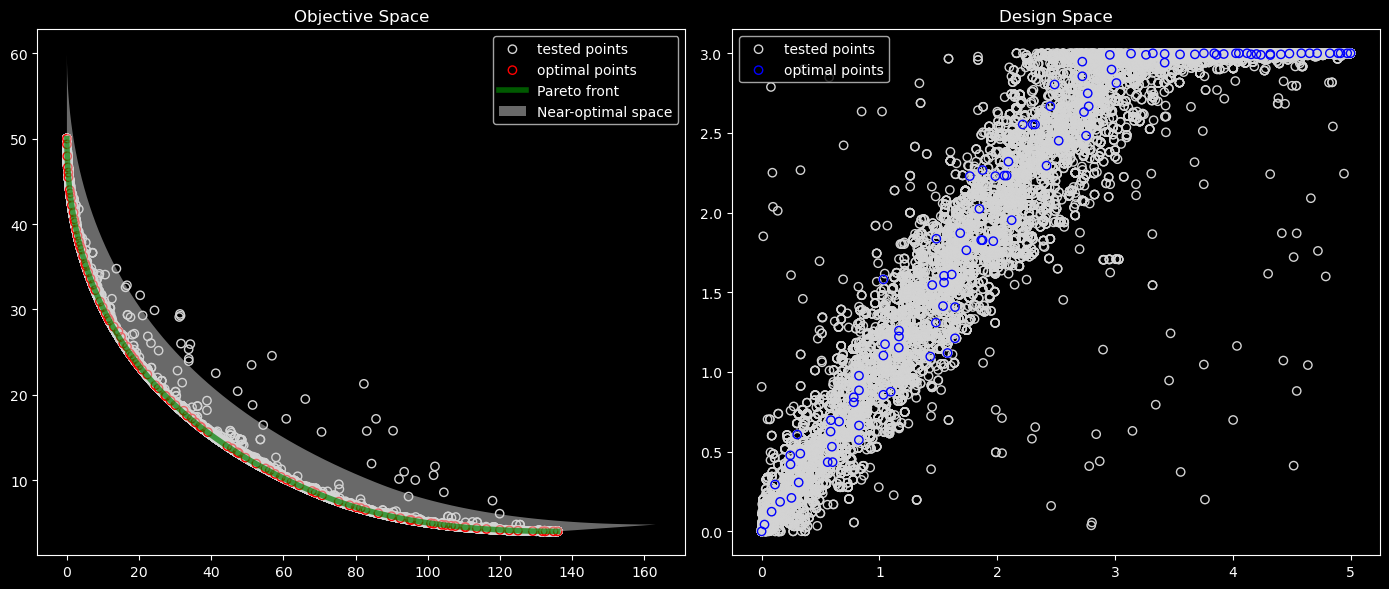

In [7]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].set_title("Objective Space")
    ax[0].scatter(F_hist[:,0], F_hist[:,1], facecolor="none", edgecolor="lightgray", label='tested points')
    ax[0].scatter(res.F[:,0], res.F[:,1], facecolor="none", edgecolor="red", label='optimal points')
    ax[0].plot(F[:,0], F[:,1], color="g", alpha=0.7, label='Pareto front', lw=4)
    ax[0].fill(np.append(f1, F1[::-1]), np.append(f2, F2[::-1]), 'lightgrey', alpha=alpha, label="Near-optimal space")
    ax[0].legend()


    ax[1].set_title("Design Space")
    ax[1].scatter(X_hist[:,0], X_hist[:,1], facecolor="none", edgecolor="lightgray", label='tested points')
    ax[1].scatter(res.X[:,0], res.X[:,1], facecolor="none", edgecolor="blue", label='optimal points')
    ax[1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [8]:
from osier import distance_matrix, farthest_first, check_if_interior

### Create the slack front

In [9]:
slack_front = np.c_[F1,F2]

### Check for points that are bounded within the Pareto front and the slacked front

In [21]:
int_pts = check_if_interior(points=F_hist, par_front=F, slack_front=slack_front)
X_int = X_hist[int_pts]
F_int = F_hist[int_pts]

### Create a distance matrix

This matrix stores the distances from one point to every other point.

In [22]:
%time D = distance_matrix(X=X_int)

CPU times: user 6.13 ms, sys: 4.29 ms, total: 10.4 ms
Wall time: 9.36 ms


### Calculate the farthest points

In [31]:
n_pts = 10
idxs = farthest_first(X=X_int, D=D, n_points=n_pts)

In [32]:
F_select = F_int[idxs]
X_select = X_int[idxs]

### Plot!

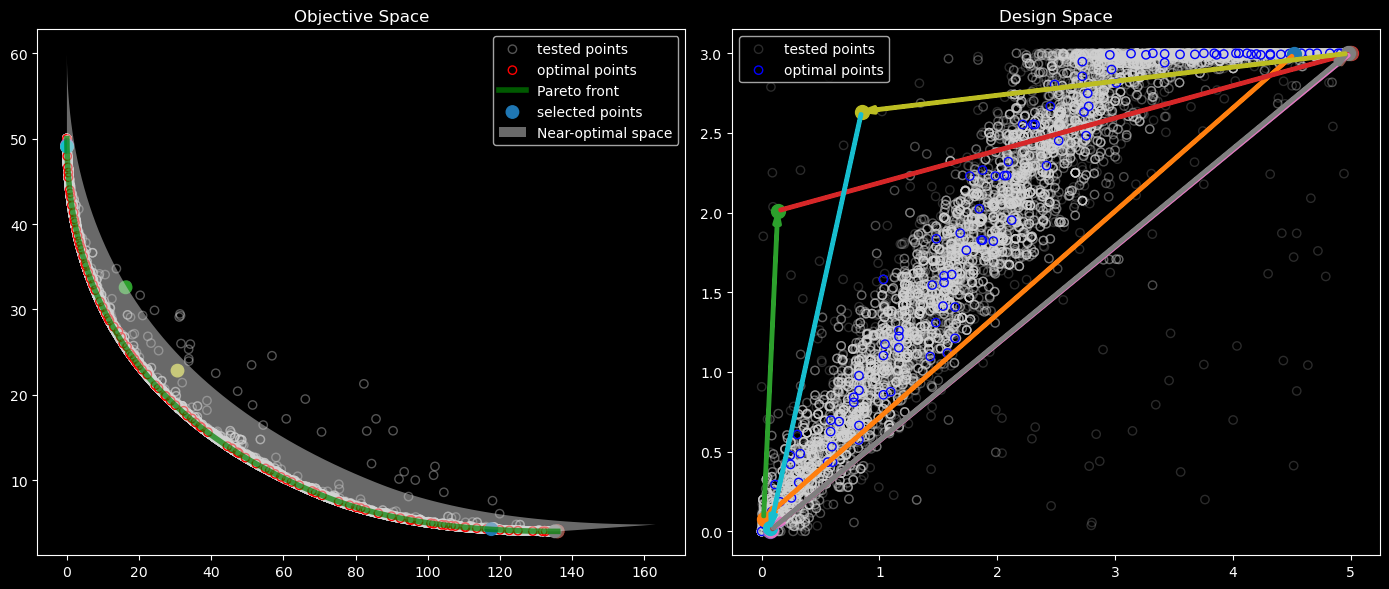

In [71]:
from mycolorpy import colorlist as mcp
import matplotlib as mpl
import matplotlib.patches as patches

cmap_name = 'tab10'
color1=mcp.gen_color(cmap=cmap_name,n=n_pts)
cmap = plt.get_cmap(cmap_name, n_pts)

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,2, figsize=(14,6))

    ax[0].set_title("Objective Space")
    ax[0].scatter(F_hist[:,0], F_hist[:,1], facecolor="none", edgecolor="lightgray", alpha=0.4,label='tested points')
    ax[0].scatter(res.F[:,0], res.F[:,1], facecolor="none", edgecolor="red", label='optimal points')
    ax[0].plot(F[:,0], F[:,1], color="g", alpha=0.7, label='Pareto front', lw=4)
    ax[0].scatter(F_select[:,0], F_select[:,1], c=color1, s=80, label='selected points')

    ax[0].fill(np.append(f1, F1[::-1]), np.append(f2, F2[::-1]), 'lightgrey', alpha=alpha, label="Near-optimal space")
    ax[0].legend()


    ax[1].set_title("Design Space")
    ax[1].scatter(X_hist[:,0], X_hist[:,1], facecolor="none", edgecolor="lightgray", alpha=0.2, label='tested points')
    ax[1].scatter(res.X[:,0], res.X[:,1], facecolor="none", edgecolor="blue", label='optimal points')
    ax[1].legend(loc='upper left')

    style = "Simple, tail_width=0.5, head_width=4, head_length=8"
    arrows = []
    prev = X_select[0]
    for i, (c, (x, y)) in enumerate(zip(color1,X_select)):
        ax[1].scatter(x, y, color=c, s=100)
        if i == 0:
            pass
        else:
            kw = dict(arrowstyle=style, color=c, linewidth=3)
            curr = (x,y)
            arrows.append(patches.FancyArrowPatch(prev, curr, **kw))
            prev = curr

    for a in arrows:
        ax[1].add_patch(a)

    plt.tight_layout()
    plt.show()

In [65]:
cols = [f'f{i}' for i in range(2)]

In [75]:
df = pd.DataFrame(dict(zip(cols,F_select.T)))

In [73]:
x_cols = [f'x{i}' for i in range(2)]

In [74]:
x_df = pd.DataFrame(dict(zip(x_cols,X_select.T)))
x_df

,x0,x1
0,4.521370,2.993094
1,0.016638,0.078078
2,0.136938,2.011403
3,5.000000,2.999023
4,0.072609,0.003982
5,4.998769,2.999243
6,0.081707,0.011328
7,4.980115,2.999243
8,0.849152,2.634428
9,0.072609,0.021876


In [76]:
pd.concat([df, x_df], axis=1)

,f0,f1,x0,x1
0,117.605587,4.256758,4.521370,2.993094
1,0.025492,49.059217,0.016638,0.078078
2,16.257969,32.581087,0.136938,2.011403
3,135.976545,4.003911,5.000000,2.999023
4,0.021152,49.239377,0.072609,0.003982
5,135.932589,4.003030,4.998769,2.999243
6,0.027218,49.076447,0.081707,0.011328
7,135.188025,4.003424,4.980115,2.999243
8,30.645070,22.825472,0.849152,2.634428
9,0.023002,49.060905,0.072609,0.021876


In [79]:
df['designs'] = [d for d in X_select]

In [80]:
df

,f0,f1,designs
0,117.605587,4.256758,"[4.521369655301458, 2.993094259730677]"
1,0.025492,49.059217,"[0.016637775520479903, 0.07807786399137573]"
2,16.257969,32.581087,"[0.13693796598963082, 2.011402530535207]"
3,135.976545,4.003911,"[4.999999999999974, 2.9990225566087565]"
4,0.021152,49.239377,"[0.07260899413133881, 0.00398213579635065]"
5,135.932589,4.003030,"[4.998768744680394, 2.9992429379992984]"
6,0.027218,49.076447,"[0.08170745441631755, 0.011328305952134077]"
7,135.188025,4.003424,"[4.98011526979994, 2.9992429379992984]"
8,30.645070,22.825472,"[0.8491520978228445, 2.6344275102882393]"
9,0.023002,49.060905,"[0.07260899413133881, 0.02187555121712781]"
